<hr style="height:2pt">

**Install below package using terminal**

"conda install -c glemaitre imbalanced-learn"

In [ ]:
!pip install --upgrade pip
!pip install -U sklearn
!pip install imblearn
!pip install textblob
!pip install -U imbalanced-learn
!pip install xgboost
!pip install -U seaborn

In [ ]:
import sys
print(sys.executable)

import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from IPython.display import display

import random

c:\Users\ianka\Projects\loan_acceptance_census_analysis\.venv\Scripts\python.exe


ModuleNotFoundError: No module named 'numpy'

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import FunctionTransformer 
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import cross_val_predict 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report

from sklearn.svm import SVC 
from xgboost.sklearn import XGBClassifier 
import itertools
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from textblob import Word
from sklearn.ensemble import VotingClassifier 

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

# Prediction of Charge-Offs

We will consider the loan status as the response variable, a binary outcome for a loan with value 0 for fully paid and 1 for Charged Off.

We will work with data previously cleaned and augmented with census information. We will use a subset of loans which were fully paid or charged-off.

In [ ]:
np.random.seed(9999)

In [ ]:
# Entire data - please use this data set when you run it on AWS or a powerful machine.
#df_loan_accepted_census_cleaned = pd.read_csv('http://digintu.tech/tmp/cs109a/df_loan_accepted_census_cleaned_closed_2007-2015.csv')

# 1% of the data
# 1% of all closed loans between 2007 and 2015, cleaned and augmented with census data - 73 MB
#df_loan_accepted_census_cleaned = pd.read_csv('http://digintu.tech/tmp/cs109a/df_loan_accepted_census_cleaned_closed_2007-2015_10.csv').sample(frac=.1) 

# 10% of the data
# 10% of all closed loans between 2007 and 2015, cleaned and augmented with census data - 73 MB
df_loan_accepted_census_cleaned = pd.read_csv('https://s3.amazonaws.com/ruxton.ai/df_loan_accepted_census_cleaned.csv')

In [ ]:
df_loan = df_loan_accepted_census_cleaned.copy()
df_loan = df_loan[df_loan.loan_status.isin(['Charged Off', 'Fully Paid'])]

## Features Selection

Our goal is now to do exploratory analysis using predictive models in order to find important features in closed loans.

Statistical tests can be used to select features that have the strongest relationship with the response variable. 

The Recursive Feature Elimination works by recursively removing variables and building a model on those variables that remain. Model accuracy is used to select the variables which contribute the most to the response.

In this section we use a model-based approach of features selection using bagged trees and PCA. 



### Manual features selection

Using domain knowledge, we remove a list of features as manual feature selection. 
The following list of predictors are those which we MUST not use since they are data gathered AFTER the loan is funded. The reason to exclude them is because these features will not be available in unseen future dataset. Those features are highly correlated to charged-off loans and would otherwise bias our results.

In [ ]:
not_predictor = [
'chargeoff_within_12_mths',   
'collection_recovery_fee',
'debt_settlement_flag',
'debt_settlement_flag_date',
'deferral_term',
'funded_amnt_inv',
'funded_amnt',
'hardship_amount',
'hardship_dpd',
'hardship_end_date',
'hardship_flag',
'hardship_last_payment_amount',
'hardship_length',
'hardship_loan_status',
'hardship_payoff_balance_amount',
'hardship_reason',
'hardship_start_date',
'hardship_status',
'hardship_type',
'last_credit_pull_d',
'last_fico_range_high',
'last_fico_range_low',
'last_pymnt_amnt',
'last_pymnt_d',
'next_pymnt_d',
'orig_projected_additional_accrued_interest',
'out_prncp',
'out_prncp_inv',
'payment_plan_start_date',
'pymnt_plan',
'recoveries',
'settlement_amount',
'settlement_date',
'settlement_percentage',
'settlement_status',
'settlement_term',
'total_pymnt',
'total_pymnt_inv',
'total_rec_int',
'total_rec_late_fee',
'total_rec_prncp',
'verification_status'
]

**Dropping non-relevant columns**


Features like 'index', 'id', 'url' and so on are dropped as they are not relevant to our goal of loan status prediction.

We drop the index column.

In [ ]:
not_predictor  += ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1']

We drop the id, URL

In [ ]:
not_predictor  += ['id', 'url']

We drop the employment title, loan title and description, which contains too many distinct values and cannot be easily categorized.

In [ ]:
not_predictor += ['emp_title', 'title', 'desc']

We drop the success flag since it contains the same information as the loan status.

In [ ]:
not_predictor += ['success']

We remove following the issue date, quarter and year, which is less relevant for future loans, we only keep the issue month (Jan to Dec).

In [ ]:
not_predictor += ['issue_q', 'issue_d']

The grade and subgrade are categories which the LendingClub match to interest rates. Although the categories are fixed, the interest rate can slightly change within each category over the time. 

The term is calculated using the amount and the interest rate.

It follows that `int_rate`, `grade`, `sub_grade` are correlated. Furthermore `loan_amnt`, `int_rate` and `term` define the `installment`. These relationships would bring collinearity into our model for features selection.

We will therefore work with `loan_amnt`, `grade`, `sub_grade` and `term`. If it comes out that these features are important for predicting charge-off, we will conclude that their related variables `int_rate`, and `installment` are also important.

In [ ]:
not_predictor += ['int_rate', 'installment']

As far as FICO is concerned, there are 6 variables. Four of them are determined at the initial loan application, thus we can use them. It doesn't seem that they are updated. 

These 2 are significant and collinear, so only one needs to be selected. We choose

    - fico_range_high
    - fico_range_low

These 2 are not so significant and, we believe are used for joint applications.

    - sec_app_fico_range_high
    - sec_app_fico_range_low


However, These two are created, and undoubtedly updated, throughout the loan life. They should not be used:

    - last_fico_range_high
    - last_fico_range_low

In [ ]:
not_predictor += ['sec_app_fico_range_high', 'sec_app_fico_range_low', 'last_fico_range_high', 'last_fico_range_low']

As our EDA has shown, information related to gender, race, zip code and state can lead to some unfair handling by a predictive model. We will assume here that removing them as predictor would solve this issue. We further assume that the remaining predictors will not be correlated in any way with census information.

In [ ]:
not_predictor += ['addr_state','zip_code','Population', 'median_income_2016', 
               'female_pct', 'male_pct', 
               'Black_pct', 'White_pct', 'Native_pct', 'Asian_pct', 'Hispanic_pct', 
               'household_family_pct', 'poverty_level_below_pct', 'Graduate_Degree_pct', 'employment_2016_rate']

#### **Correlation and redundancy**

Features-pairs which correlate by either -1 or +1 can be considered to be redundant. However High absolute correlation does not imply redundancy of features in the context of classification, see textbook [4] . Therefore we will have a closer look at each correlation.

In [ ]:
# source code adapted from [5]
def find_high_correlated_features(frame):
    new_corr = frame.corr()
    new_corr.loc[:,:] = np.tril(new_corr, k=-1) 
    new_corr = new_corr.stack()
    print(new_corr[(new_corr > 0.80) | (new_corr < -0.80)])
    
predictor = list(set(df_loan_accepted_census_cleaned.columns.values)-set(not_predictor))
find_high_correlated_features(df_loan_accepted_census_cleaned[predictor])   

pub_rec_bankruptcies  mths_since_last_record        0.814032
total_bal_ex_mort     total_il_high_credit_limit    0.887616
fico_range_high       fico_range_low                1.000000
num_sats              open_acc                      0.959349
tot_cur_bal           tot_hi_cred_lim               0.982460
num_actv_rev_tl       num_rev_tl_bal_gt_0           0.984812
total_bc_limit        total_rev_hi_lim              0.820915
                      bc_open_to_buy                0.855208
num_op_rev_tl         open_acc                      0.808957
                      num_sats                      0.842700
                      num_rev_tl_bal_gt_0           0.817170
                      num_actv_rev_tl               0.813259
num_rev_accts         num_bc_tl                     0.853090
                      num_op_rev_tl                 0.812411
dtype: float64


In [ ]:
not_predictor += ['fico_range_low','num_rev_tl_bal_gt_0', 'num_actv_rev_tl','open_il_12m','open_rv_12m','avg_cur_bal','tot_hi_cred_lim','num_bc_tl']

`fico_range_low` and `fico_range_low` are highly correlated. We keep the high value.

The Number of revolving trades with balance >0 `num_rev_tl_bal_gt_0` and the Number of currently active revolving trades `num_actv_rev_tl` are highly correlated with the Number of currently active bankcard accounts `num_actv_bc_tl`. It is safe to remove the formers for our classification task for identifying fully paid loans from charged-off ones.

The number of open credit lines `open_acc` (preapproved loans between a financial institution and borrower that may be used repeatedly up to a certain limit and can subsequently be paid back prior to payments coming due) in the borrower's credit file is highly correlated with the Number of satisfactory accounts (good standing accounts that have been paid in full and on time) `num_sats`. We will keep both features.

`open_il_24m` and `open_il_12m` are the Number of installment accounts opened in past 24 and 12 months respectively. Both values are strongly correlated. We will consider 24 months period since it includes 12 months period. We will handle `open_rv_12m` and `open_rv_24m` in the same way (Number of revolving trades opened in past 12, resp. 24 months).

`tot_cur_bal`, `avg_cur_bal` Total and average current balance of all accounts are strongly related to `tot_hi_cred_lim`, Total high credit/credit limit. We will only keep the total current balance.

`num_rev_accts` Number of revolving accounts (account created by a lender to represent debts where the outstanding balance does not have to be paid in full every month by the borrower to the lender) and `num_bc_tl` Number of bankcard accounts are correlated. This is because credit cards are usually considered as revolving accounts. We assume that the number of revolving accounts better describe the risk for loans and we will remove the number of bankcard accounts.

`total_bal_ex_mort` Total credit balance excluding mortgage and `total_il_high_credit_limit` Total installment high credit/credit limit are correlated. With an installment account, the borrower pays back the loan plus interest by making regular payments for a fixed amount of time. We will keep both features.

`bc_open_to_buy` Total open to buy on revolving bankcards (credit cards) can be considered as a subset of `total_bc_limit` Total bankcard high credit/credit limit, but both information can differ in many situations. We keep both.

**Features values distribution**

For each remaining feature, we will plot the distribution of their values in both charged-off and fully paid categories. This will help us seing how they might impact the decision boundaries.

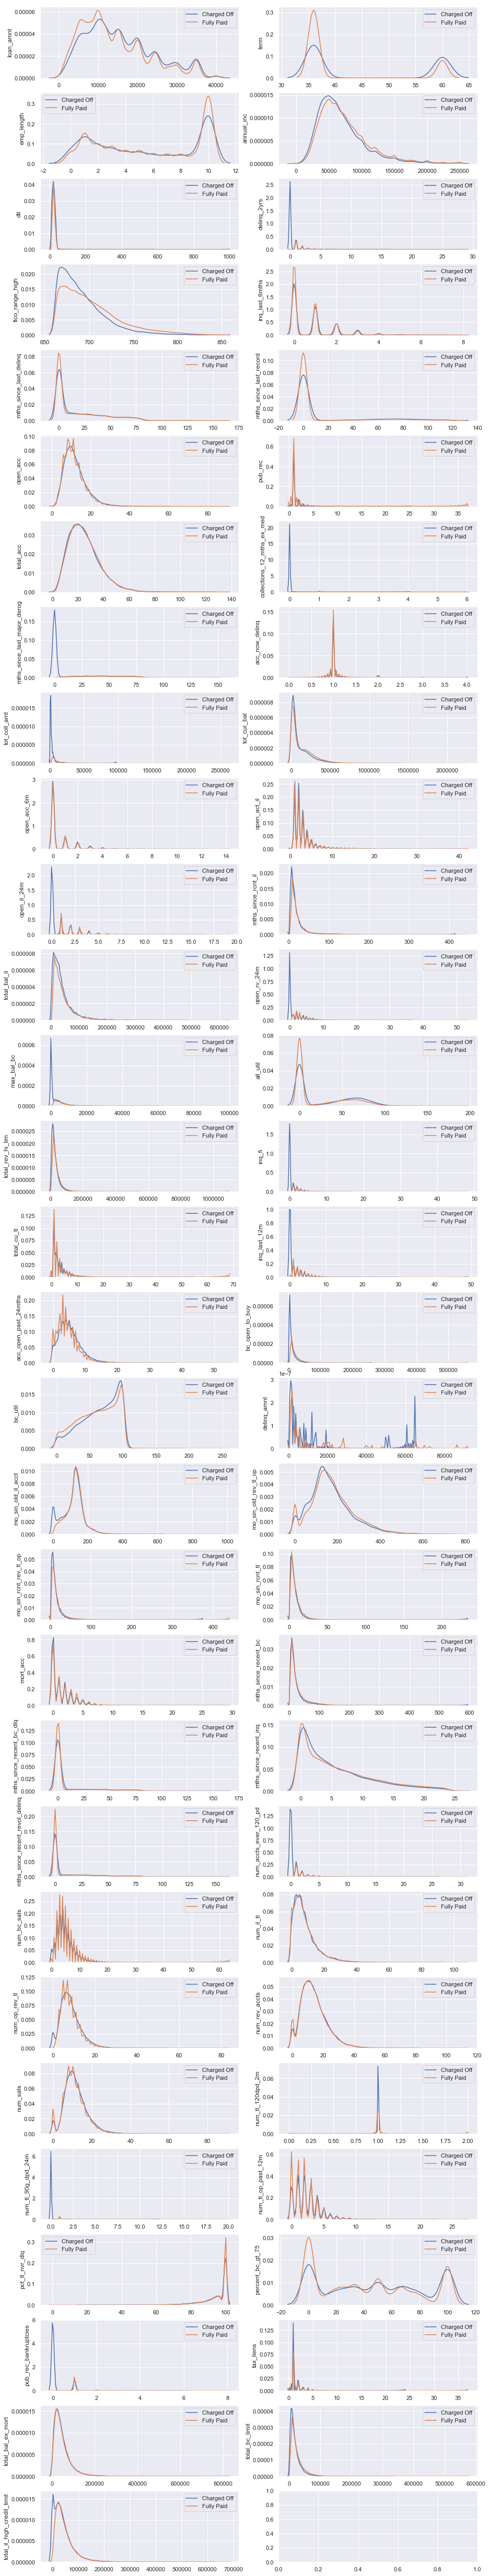

In [ ]:
nb = 1
for var in [x for x in df_loan.columns.values if x not in not_predictor]:
    if df_loan[var].dtype == np.float64 or df_loan[var].dtype == np.int64:
        nb = nb + 1
fig, ax = plt.subplots(nb//2, 2, figsize=(15,90))
i = 0
for var in [x for x in df_loan.columns.values if x not in not_predictor]:
    if df_loan[var].dtype == np.float64 or df_loan[var].dtype == np.int64:
        sns.kdeplot(df_loan[df_loan.loan_status=='Charged Off'][var], label='Charged Off', ax=ax[i//2,i % 2])
        sns.kdeplot(df_loan[df_loan.loan_status!='Charged Off'][var], label='Fully Paid', ax=ax[i//2,i % 2])
        ax[i//2,i % 2].set_ylabel(var)
        i = i + 1
        

Looking at the plots above we see that the distribution for census-related features is almost the same accross both classes of loans. We will investigate those features closer using mode-based features selection in the next section.

**One-hot encoding**

We turn the loan status into a binary variable

In [ ]:
df_loan.replace({'loan_status':{'Charged Off': 1, 'Fully Paid': 0}}, inplace=True)
df_loan.loan_status = df_loan.loan_status.astype('int')

We convert the `earliest_cr_line` feature to the number of years between the earliest credit line and the year when the loan was requested.

We turn categorical features into binary variables.

In [ ]:
df_loan.replace({'term':{36: 1, 60: 0}},inplace=True)

In [ ]:
df_loan = pd.get_dummies(df_loan, columns=['emp_length', 'home_ownership','purpose','issue_m',
                                               'grade', 'sub_grade','earliest_cr_line'], drop_first=True)

**Remove irrelevant features**

Let's remove all indentified features above.

In [ ]:
df_loan.drop(columns=list(set(not_predictor) & set(df_loan.columns.values)), inplace=True)

### Imbalanced Dataset

As we see below, the data is unbalanced, with Fully Paid loans being the majority class.

In [ ]:
nb = df_loan.loan_status.value_counts()
nb

0    106554
1     26577
Name: loan_status, dtype: int64

Here, 0 - Fully Paid loans and 1 - Charged Off loans. 

In [ ]:
print("We notice, {0:.2%} of the total loans are Charged Off, and about {1:.2%} loans are Fully Paid.".format(nb[0]/np.sum(nb),nb[1]/np.sum(nb)))

We notice, 80.04% of the total loans are Charged Off, and about 19.96% loans are Fully Paid.


**Train/Test/Validation Data Split**

`X` is the feature matrix. `Y` is the response vector.

In [ ]:
X, Y = df_loan[df_loan.columns.difference(['loan_status'])], df_loan['loan_status']

We choose to split the whole dataset to 90% training, 10% test, with stratify, resulting in consistent class distribution between training and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, stratify=Y)

Let's further split the training set into a 80% training and a 20% validation set.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [ ]:
print("We verify that the proportion of Charged Off is about the same: {0:.2%} in train, {1:.2%} in val and {2:.2%} in test".format(len(y_train[y_train==0])/len(y_train),
                                                                                                                                   len(y_val[y_val==0])/len(y_val),
                                                                                                                                   len(y_test[y_test==0])/len(y_test)))

We verify that the proportion of Charged Off is about the same: 80.04% in train, 80.04% in val and 80.04% in test


We will now have a closer look at the imbalanced classes.

Let's reduce the dimension of a subset of the data using Principal Component Analysis (PCA) and display the imbalanced classes in a 2D plot.

In [ ]:
X_train_subset = X_train[:100]
y_train_subset = y_train[:100]
pca = PCA(n_components=2)
X_train_subset = pca.fit_transform(X_train_subset)

In [ ]:
y_train_subset.value_counts()

0    79
1    21
Name: loan_status, dtype: int64

In [ ]:
# source code adapted from [6]
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    labels = ['Charged Off', 'Fully Paid']
    for d, l, c, m in zip(labels, np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=d, marker=m, alpha=.5
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.show()

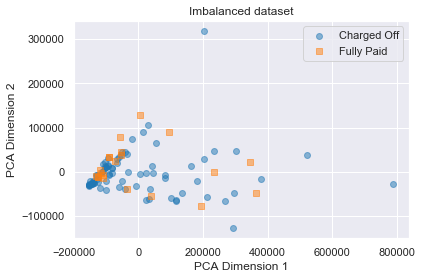

In [ ]:
plot_2d_space(X_train_subset, y_train_subset, 'Imbalanced dataset')

The plot above is a visual confirmation of the imbalanced classes in our data.

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of either removing samples from the majority class (under-sampling) or adding more examples from the minority class (over-sampling). Both strategies can also be applied at the same time.

As shown below with under-sampling, we tend to loose valuable information, which can increase bias.

58 random samples removed


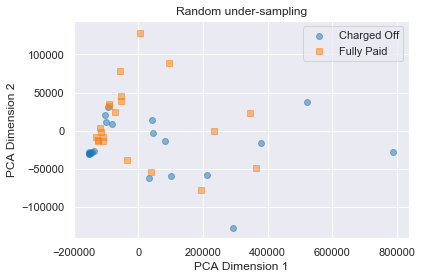

In [ ]:
rus = RandomUnderSampler()
X_train_subset_rus, y_train_subset_rus= rus.fit_resample(X_train_subset, y_train_subset)

print(X_train_subset.shape[0] - X_train_subset_rus.shape[0], 'random samples removed')
plot_2d_space(X_train_subset_rus, y_train_subset_rus, 'Random under-sampling')

In over-sampling the most naive strategy is to generate new samples by randomly sampling with replacement the current available samples, which can cause overfitting.

58 random samples added


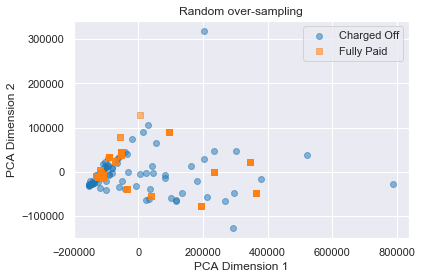

In [ ]:
ros = RandomOverSampler()
X_train_subset_ros, y_train_subset_ros = ros.fit_resample(X_train_subset, y_train_subset)
print(X_train_subset_ros.shape[0] - X_train_subset.shape[0], 'random samples added')
plot_2d_space(X_train_subset_ros, y_train_subset_ros, 'Random over-sampling')

A number of more sophisticated resapling techniques have been proposed in the scientific literature, especially using the Python library imbalanced-learn [7]. SMOTE (Synthetic Minority Oversampling TEchnique) consists of creating new samples for the minority class, by picking a sample from that class and computing the k-nearest neighbors, then adding a new sample between the chosen sample and its neighbors.

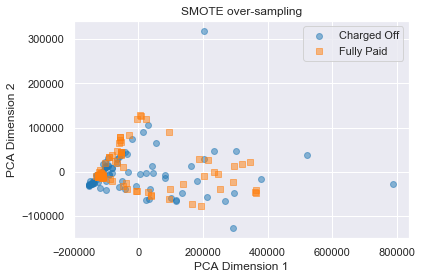

In [ ]:
smote = SMOTE(sampling_strategy='minority')
X_train_subset_sm, y_train_subset_sm = smote.fit_resample(X_train_subset, y_train_subset)

plot_2d_space(X_train_subset_sm, y_train_subset_sm, 'SMOTE over-sampling')

**We will use SMOTE to balance our training dataset.** 

In [ ]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
print('The Charged-Off to Fully Paid ratio in the balanced training set is now: ', len(y_train[y_train==0])/len(y_train[y_train==1]))

The Charged-Off to Fully Paid ratio in the balanced training set is now:  1.0


### Model-based features selection

**Insights on features importance**

Looking at the results above, we can bring in following conclusions:

- The term is the most important element each investor has to care about. 68-months loans are highly risky.
- The purpose of loan for credit cards payment brings more confidence to an investor.
- Borrowers who have 10 or more years verified working experience are the most trustworthy investment.
- Home ownership plays a significant role.
- The state of California is a significant factor to be considered when looking at the likelihood of Charged-Off
- Lenders should look at financial KPIs such as inq_last_6mths, num_tl_op_past_12m and acc_open_past_24mths; not just at FICO score, which are less relevant than these KPIs.
- Debt-to-income ratio and annual income can be missleading, and shoudn't be always considered as the most important factors.
- The time of the year when the loan is requested is not so relevant.


We will use classifiers on the training dataset in order to get a better understanding on how features are related to loan outcome as fully paid or unpaid. This will help us reducing the dimensionality of our data by selecting the most important features.

In [ ]:
randomf = RandomForestClassifier(n_estimators=100, max_depth=None, oob_score=True).fit(X_train, y_train)

In [ ]:
print('Accuracy, Training Set: {0:0.2%}'.format(randomf.score(X_train, y_train)))
print('OOB Score, Training Set: {0:0.2%}'.format(randomf.oob_score_))
print('Accuracy, Validation Set: {0:0.2%}'.format(randomf.score(X_val, y_val)))

Accuracy, Training Set: 100.00%
OOB Score, Training Set: 87.64%
Accuracy, Validation Set: 79.89%


The random forest is clearly overfit, and is obviously picking the majority class in the validation set.

Below we have a ranking of features as computed by our random forest, depending on their Gini importance in the prediction of loan outcome.

In [ ]:
feature_importances = pd.DataFrame(randomf.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance', ascending=False).reset_index().rename(columns={'index':'feature'})
feature_importances.head(10)

,feature,importance
0,term,0.040835
1,inq_last_6mths,0.032203
2,grade_B,0.027779
3,num_tl_op_past_12m,0.024517
4,percent_bc_gt_75,0.020947
5,fico_range_high,0.020251
6,acc_open_past_24mths,0.019361
7,loan_amnt,0.017740
8,mths_since_recent_inq,0.017714
9,dti,0.016818


**Important Features**

We will now use SKLearn meta-transformet SelectFromModel to discard irrelevant features using the features importance produced by our random forest.

In [ ]:
fs_model = SelectFromModel(randomf, prefit=True)
outcome = fs_model.get_support()
features_list_orig = X.columns.values
features_list_new = []
for i in range(0,len(features_list_orig)):
    if outcome[i]:
        features_list_new.append(features_list_orig[i])
print('{} features were selected from the {} original hot-encoded ones:'.format(len(features_list_new), len(features_list_orig)))
print('')
print(features_list_new)

105 features were selected from the 793 original hot-encoded ones:

['acc_open_past_24mths', 'all_util', 'annual_inc', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length_1', 'emp_length_10', 'emp_length_2', 'emp_length_3', 'emp_length_4', 'emp_length_5', 'emp_length_6', 'emp_length_7', 'emp_length_8', 'emp_length_9', 'fico_range_high', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT', 'inq_fi', 'inq_last_12m', 'inq_last_6mths', 'issue_m_Aug', 'issue_m_Dec', 'issue_m_Feb', 'issue_m_Jan', 'issue_m_Jul', 'issue_m_Jun', 'issue_m_Mar', 'issue_m_May', 'issue_m_Nov', 'issue_m_Oct', 'issue_m_Sep', 'loan_amnt', 'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mth

In [ ]:
loan_variables_selected = []
for col in df_loan_accepted_census_cleaned.columns:
    if len([s for s in features_list_new if s.startswith(col)])>0:
        loan_variables_selected.append(col)

print('After hot-decoding, they corresponds to the following {} features from the original dataset.'.format(len(loan_variables_selected)))
print('')
print(loan_variables_selected)

After hot-decoding, they corresponds to the following 60 features from the original dataset.

['loan_amnt', 'term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'purpose', 'dti', 'delinq_2yrs', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc', 'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_bc_sats', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_sats', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pc

**Design Matrix with important features**

We can now create the new design matrix using the identified important features.

In [ ]:
print("Number of predictors after one-hot encoding is: ",X_train.shape[1])

Number of predictors after one-hot encoding is:  793


In [ ]:
X_train = fs_model.transform(X_train)
X_val = fs_model.transform(X_val)
X_test = fs_model.transform(X_test)

In [ ]:
print("Number of predictors after feature selection is ", X_train.shape[1])

Number of predictors after feature selection is  105


**Principal Components Analysis**

We are interested in reducing the dimension of our data further by analysing its principal components. This will allow us to compress the important features into a reduced number of components.

We first start with scaling the data.

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

We decompose the scaled data with PCA

In [ ]:
n = X_train.shape[1]
pca_fit = PCA(n).fit(X_train_scaled)

In the plot below, we see that the dimension can be reduced to the number of components which explain at least 90% of variance in the data.

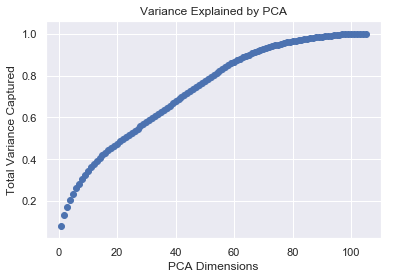

In [ ]:
pca_var = np.cumsum(pca_fit.explained_variance_ratio_)
plt.scatter(range(1,n+1),pca_var)
plt.xlabel("PCA Dimensions")
plt.ylabel("Total Variance Captured")
plt.title("Variance Explained by PCA");

We can now rebuild our design matrix using the PCA components.

In [ ]:
pca_fit = PCA(25).fit(X_train_scaled)
X_train_pca = pca_fit.transform(X_train)
X_val_pca = pca_fit.transform(X_val)
X_test_pca = pca_fit.transform(X_test)
X_train_scaled_pca = pca_fit.transform(X_train_scaled)
X_val_scaled_pca = pca_fit.transform(X_val_scaled)
X_test_scaled_pca = pca_fit.transform(X_test_scaled)

**Helper function for Design Matrix**

We summarize the above code in the function below, which create all design matrices need for our models.

In [ ]:
def get_design_matrices(df, variables = ['loan_amnt', 'term', 'sub_grade', 'grade', 'emp_length', 'home_ownership',
           'annual_inc', 'loan_status', 'purpose', 'dti', 'delinq_2yrs',
           'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
           'mths_since_last_record', 'open_acc', 'pub_rec',
            'total_acc', 'collections_12_mths_ex_med',
           'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt',
           'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths',
           'bc_open_to_buy', 'bc_util', 'delinq_amnt', 'mo_sin_old_il_acct',
           'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
           'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
           'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
           'num_accts_ever_120_pd', 'num_bc_sats',
           'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_sats',
           'num_tl_120dpd_2m',  'num_tl_90g_dpd_24m',
           'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
           'pub_rec_bankruptcies', 'tax_liens', 'total_bal_ex_mort',
           'total_bc_limit', 'total_il_high_credit_limit','earliest_cr_line']):
    
    # raw data
    df_loan = df.copy()
    df_loan = df_loan[df_loan.loan_status.isin(['Charged Off', 'Fully Paid'])]
    df_loan = df_loan[variables]
    # hot encoding
    df_loan.replace({'loan_status':{'Charged Off': 1, 'Fully Paid': 0}}, inplace=True)
    df_loan.loan_status = df_loan.loan_status.astype('int')
    df_loan.replace({'term':{36: 1, 60: 0}},inplace=True)
    df_loan = pd.get_dummies(df_loan, columns=['emp_length', 'home_ownership','purpose',
                                               'grade', 'sub_grade','earliest_cr_line'], drop_first=True)
    # design matrix
    X, Y = df_loan[df_loan.columns.difference(['loan_status'])], df_loan['loan_status']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, stratify=Y)
    X_test_df = X_test
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)
    # upsampling
    smote = SMOTE(sampling_strategy='minority')
    X_train, y_train = smote.fit_resample(X_train, y_train)
    X_val, y_val = smote.fit_resample(X_val, y_val)
    # features selection
    randomf = RandomForestClassifier(n_estimators=100, max_depth=None, oob_score=True).fit(X_train, y_train)
    fs_model = SelectFromModel(randomf, prefit=True)
    X_train = fs_model.transform(X_train)
    X_val = fs_model.transform(X_val)
    X_test = fs_model.transform(X_test)
    # scaling
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    # pca transform
    pca_fit = PCA(.9).fit(X_train_scaled)
    X_train_pca = pca_fit.transform(X_train)
    X_val_pca = pca_fit.transform(X_val)
    X_test_pca = pca_fit.transform(X_test)
    X_train_scaled_pca = pca_fit.transform(X_train_scaled)
    X_val_scaled_pca = pca_fit.transform(X_val_scaled)
    X_test_scaled_pca = pca_fit.transform(X_test_scaled)
    return X_test_df, X_train, y_train, X_val, y_val, X_test, y_test, X_train_scaled, X_val_scaled, X_test_scaled, X_train_scaled_pca, X_val_scaled_pca, X_test_scaled_pca

In [ ]:
X_test_df, X_train, y_train, X_val, y_val, X_test, y_test, X_train_scaled, X_val_scaled, X_test_scaled,X_train_scaled_pca, X_val_scaled_pca, X_test_scaled_pca = get_design_matrices(df_loan_accepted_census_cleaned)

## Classification Models

In the previous section we used a model-based approach for identifying the important features which most probably determine the failure or success of a loan.

Using the features selected, we will now investigate the performance of several models on the validation set via cross-validation. Each model will be trained on the training set. We will also check if dimension reduction via PCA improves the accuracy. 

At the end we will investigate if ensemble technique via stacking of base learners improves classification results.


### Scoring

In classification problems, we can distinguish between the following metrics, whereby **the positive class is Charge Off** and **the negative class is Fully Paid**:

- **Recall or Sensitivity or TPR (True Positive Rate)**: Number of loans correctly identified as positive (fully paid) out of total true positives - TP/(TP+FN)
    
- **Specificity or TNR (True Negative Rate)**: Number of loans correctly identified as negative (charged-off) out of total negatives - TN/(TN+FP)

- **Precision**: Number of loans correctly identified as positive (fully paid) out of total items identified as positive - TP/(TP+FP)
    
- **False Positive Rate or Type I Error**: Number of loans wrongly identified as positive (fully paid) out of total true negatives - FP/(FP+TN)
    
- **False Negative Rate or Type II Error**: Number of loans wrongly identified as negative (charged-off) out of total true positives - FN/(FN+TP)

- A **Confusion Matrix**: visual representation of the number of TP, TN, FP and FN.

- **Accuracy**: Percentage of total items classified correctly - (TP+TN)/(N+P)

- **F1 Score**: Harmonic mean of precision and recall given by - F1 = 2xPrecisionxRecall /(Precision + Recall)

- **ROC-AUC Score**: Area under curve of sensitivity (TPR) vs. specificity (TNR).

- **Log-loss**: Probabilistic confidence of accuracy. High value of log-loss means that the absolute probabilities have big difference from actual labels.  

**Scoring in investment strategy**

Insights from [8] were used in this section.

If we choose an investment strategy that uses absolute probabilistic difference, then we will  look at log-loss with care. If the final class prediction is the most important outcome and we don’t want to tune probability threshold, we will rather use AUC score. But if the threshold is well tuned, then F1 will be the scoring to use.

In loan classification, where positive labels (charged-offs) are few, we would like our model to predict positive classes correctly and hence we will sometime prefer those models which are able to classify these positive labels. Log-loss usually fails to identify model which produces too many false negatives because the log-loss function is symmetric and does not differentiate between classes.  Both F1 score and ROC-AUC score can perform well for class imbalance. F1 is better suit for situations where the negative class is small. Since an investor would care more about the minority class (charged-off loans) in number independent of the fact whether it is positive or negative, then **we think that ROC-AUC score would make sense as benchmark measure.**

**Helper functions for scoring metrics**

The source code from [9] was adjusted in the functions below.

In [ ]:
# dataframe where we track all cross-validation scoring metrics
df_cv_scores = pd.DataFrame({'model':['dummy'], 'accuracy':[0], 'f1':[0], 'roc_auc':[0]}, 
                            columns=['accuracy','f1','roc_auc'], index=['model'])
df_cv_scores_pca = df_cv_scores.copy()

df_y_pred_probas = pd.DataFrame() 
df_y_preds = pd.DataFrame() 

In [ ]:
# function adjusts class predictions based on the prediction threshold
def adjust_proba(probs, threshold):
    return [1 if proba >= threshold else 0 for proba in probs]

In [ ]:
# function for computing 5-fold cross-validation scoring scores
def predict_evaluate_cv(model, X, y, df_cv_scores):
    cv = StratifiedKFold(n_splits=3, random_state=9999,shuffle=True) 
    score_accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
    score_f1 = cross_val_score(model, X, y, cv=cv, scoring='f1').mean()
    score_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc').mean()
    df_cv_scores.loc[model.__class__.__name__] = [score_accuracy, score_f1, score_auc]
    print('K-fold cross-validation results on validation set:')
    print(" average accuracy is {0:0.2%}".format(score_accuracy))
    print(" average F1 is {0:0.2%}".format(score_f1))
    print(" average roc_auc is {0:0.2%}".format(score_auc))

In [ ]:
# function for computing the confusion matrix
def predict_evaluate_cm(model, X, y, threshold=.5):
    model_name = model.__class__.__name__
    classes = ['Fully Paid', 'Charged-Off']
    y_true = y
    if model_name == 'SVC':
        y_pred_proba = model.decision_function(X)
    else:
        y_pred_proba = model.predict_proba(X)[:, 1]
    df_y_pred_probas[model_name] = y_pred_proba
    y_pred = adjust_proba(y_pred_proba, threshold)
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float')
    np.set_printoptions(precision=2)
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="gray" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.rcParams["axes.edgecolor"] = "0.85"
    plt.show()

In [ ]:
# function for compution the roc plot
def predict_evaluate_roc(model, X, y, threshold=.5):
    y_pred = model.predict(X)
    model_name = model.__class__.__name__
    df_y_preds[model_name] = y_pred
    if model_name == 'SVC':
        y_pred_proba = model.decision_function(X)
    else:
        y_pred_proba = model.predict_proba(X)[:, 1]
    [fpr, tpr, thr] = roc_curve(y, y_pred_proba)

    idx = np.min(np.where(tpr > threshold))
    plt.figure()
    plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
    plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (recall)', fontsize=14)
    plt.title('Receiver operating characteristic (ROC) curve - {}'.format(model_name))
    plt.legend(loc="lower right")
    plt.show()

    print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
          "and a specificity of %.3f" % (1-fpr[idx]) + 
          ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

In [ ]:
# global function for fitting, cross-validating and evaluating a given classifier
def fit_predict_evaluate(model, Xtrain, ytrain, Xval, yval, df_cv_scores):
    model.fit(Xtrain, ytrain)
    print(model.__class__.__name__+":")
    print('Accuracy score on training set is {0:0.2%}'.format(model.score(Xtrain, ytrain)))
    predict_evaluate_cv(model, Xval, yval, df_cv_scores)
    predict_evaluate_cm(model, Xval, yval)
    predict_evaluate_roc(model, Xval, yval)
    return model

## Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier(max_depth = None)

DecisionTreeClassifier:
Accuracy score on training set is 100.00%
K-fold cross-validation results on validation set:
 average accuracy is 78.98%
 average F1 is 79.27%
 average roc_auc is 79.04%


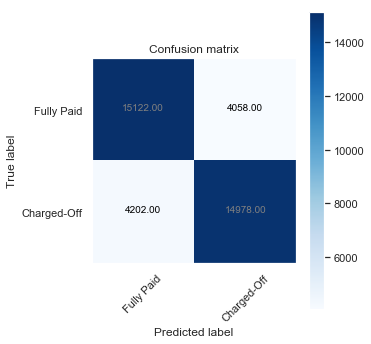

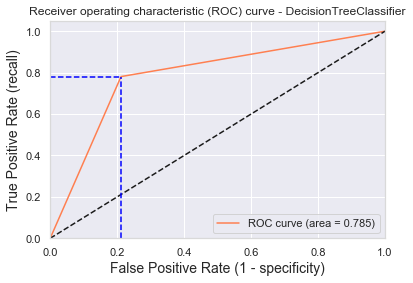

Using a threshold of 1.000 guarantees a sensitivity of 0.781 and a specificity of 0.788, i.e. a false positive rate of 21.16%.


In [ ]:
dt_model = fit_predict_evaluate(dt_model, X_train, y_train, X_val, y_val, df_cv_scores)

## Random Forest

We will now rebuilt our random forest classifier, this time using the important features.

In [ ]:
randomf_optim = RandomForestClassifier(n_estimators=200, max_depth=20)

RandomForestClassifier:
Accuracy score on training set is 98.48%
K-fold cross-validation results on validation set:
 average accuracy is 87.76%
 average F1 is 86.72%
 average roc_auc is 93.56%


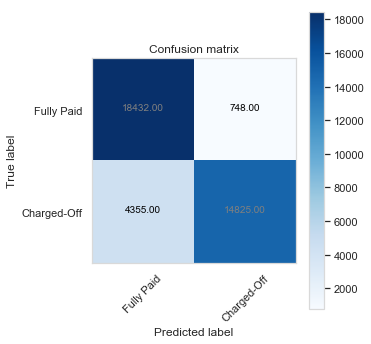

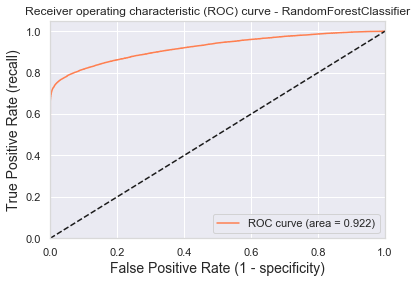

Using a threshold of 0.862 guarantees a sensitivity of 0.500 and a specificity of 1.000, i.e. a false positive rate of 0.00%.


In [ ]:
randomf_optim = fit_predict_evaluate(randomf_optim, X_train, y_train, X_val, y_val, df_cv_scores)

The random forest classifier gives the best accuracy so far.

### Please write code for XG Boosting ###


D:\yib\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:06:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier:
Accuracy score on training set is 99.93%


D:\yib\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:20:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\yib\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:21:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\yib\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:23:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\yib\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:25:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\yib\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:27:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\yib\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:30:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\yib\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:32:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\yib\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:34:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\yib\python\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
K-fold cross-validation results on validation set:
 average accuracy is 87.11%
 average F1 is 86.04%
 average roc_auc is 92.80%


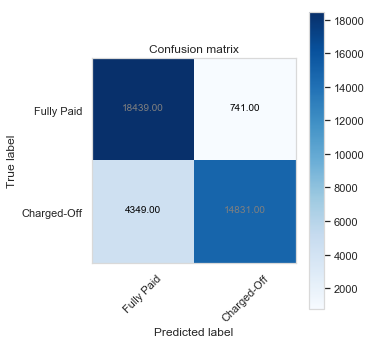

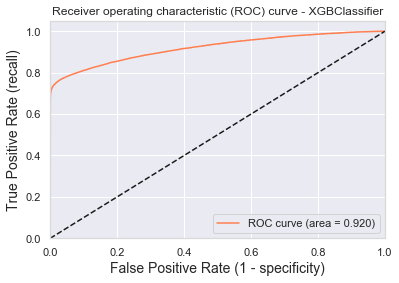

Using a threshold of 0.981 guarantees a sensitivity of 0.501 and a specificity of 1.000, i.e. a false positive rate of 0.00%.


In [ ]:
## your code here ##
xgb_model = XGBClassifier(n_estimators=200, max_depth=20,learning_rate=0.02)
xgb_optim = fit_predict_evaluate(xgb_model, X_train, y_train, X_val, y_val, df_cv_scores)

## Please write code for any other model of your choice ##

MultinomialNB:
Accuracy score on training set is 55.78%
K-fold cross-validation results on validation set:
 average accuracy is 55.59%
 average F1 is 59.35%
 average roc_auc is 55.77%


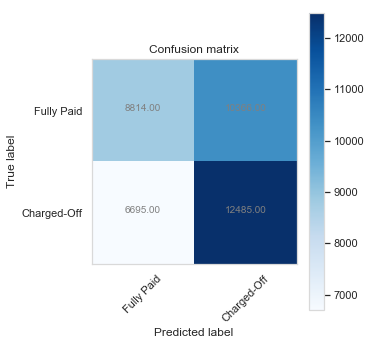

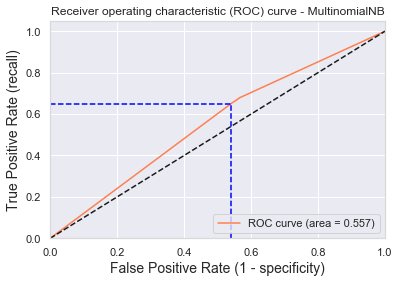

Using a threshold of 1.000 guarantees a sensitivity of 0.650 and a specificity of 0.460, i.e. a false positive rate of 53.96%.


In [ ]:
## your code here ##
MultinomialNB_model= MultinomialNB()
MultinomialNB_optim = fit_predict_evaluate(MultinomialNB_model, X_train, y_train, X_val, y_val, df_cv_scores)

## Compare the performance of all models ##

DT: 0.5414
RF: 0.6868
xgb: 0.6751
MNB: 0.5608


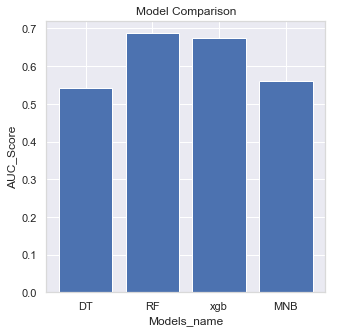

In [ ]:
## your code here ## 

import numpy as np
def predict_roc(model, X, y):
    [fpr, tpr, thr] = roc_curve(y, model.predict_proba(X)[:, 1])
    auc_roc= auc(fpr, tpr)
    return auc_roc
model=[dt_model,randomf_optim,xgb_optim,MultinomialNB_optim]
Models_name=['DT','RF','xgb','MNB']
auc_roc=[]
for i in range(len(model)):
    auc_roc_t=predict_roc(model[i], X_test, y_test)#test data#
    auc_roc.append(auc_roc_t)
    print(Models_name[i]+': '+str(np.round(auc_roc_t,4)))

plt.figure(figsize=(5,5))    
index = np.arange(len(auc_roc))
plt.bar(index,auc_roc,color='b')
plt.xlabel('Models_name')
plt.ylabel('AUC_Score')
plt.xticks(index,Models_name)
plt.title('Model Comparison')
plt.show()